<a href="https://www.kaggle.com/code/kelvinobiri/transactions-fraud-detection?scriptVersionId=248325629" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Load & Explore the Data

In [1]:
#!pip install -U imbalanced-learn==0.10.1 scikit-learn==1.1.3
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 --no-cache-dir



Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 167.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 288.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

# Load the data
transactions = pd.read_csv('/kaggle/input/credit-card-transactions/transactions.csv')
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,8,CASH_OUT,158007.12,C424875646,0.00,0.00,C1298177219,474016.32,1618631.97,0
1,236,CASH_OUT,457948.30,C1342616552,0.00,0.00,C1323169990,2720411.37,3178359.67,0
2,37,CASH_IN,153602.99,C900876541,11160428.67,11314031.67,C608741097,3274930.56,3121327.56,0
3,331,CASH_OUT,49555.14,C177696810,10865.00,0.00,C462716348,0.00,49555.14,0
4,250,CASH_OUT,29648.02,C788941490,0.00,0.00,C1971700992,56933.09,86581.10,0


## Transactions Info

In [3]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            199999 non-null  int64  
 1   type            199999 non-null  object 
 2   amount          199999 non-null  float64
 3   nameOrig        199999 non-null  object 
 4   oldbalanceOrg   199999 non-null  float64
 5   newbalanceOrig  199999 non-null  float64
 6   nameDest        199999 non-null  object 
 7   oldbalanceDest  199999 non-null  float64
 8   newbalanceDest  199999 non-null  float64
 9   isFraud         199999 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 15.3+ MB


# Analysis and Statistics

In [4]:
transactions['amount'].describe()

count    1.999990e+05
mean     1.802425e+05
std      6.255482e+05
min      0.000000e+00
25%      1.338746e+04
50%      7.426695e+04
75%      2.086376e+05
max      5.204280e+07
Name: amount, dtype: float64

In [5]:
fraud_Account = transactions[transactions['isFraud'] == 1]['nameOrig'].value_counts().head(10)
print("Top 10 Fraudulent Users:")
fraud_Account

Top 10 Fraudulent Users:


nameOrig
C1167153094    1
C2032582234    1
C921347828     1
C135832352     1
C282621115     1
C1147685648    1
C1267904754    1
C278631744     1
C1601590561    1
C226207762     1
Name: count, dtype: int64

most_type_of_transac = transactions.groupby('type')['amount'].count().sort_values(ascending=False)
most_type_of_transac.plot(kind='bar', figsize=(10, 6))
plt.title('Amount by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('amount')
plt.xticks(rotation=360)
plt.show()


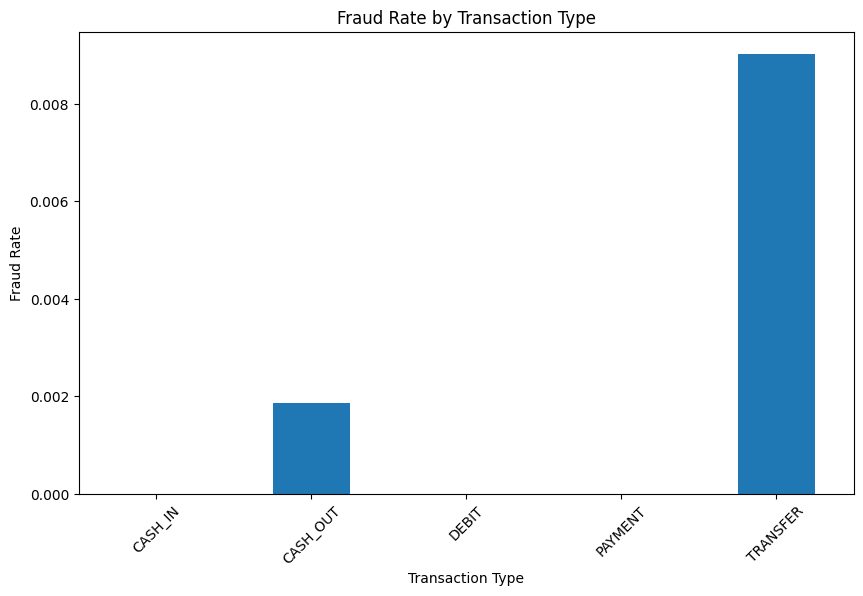

In [6]:
fraud_rate_by_type = transactions.groupby('type')['isFraud'].mean()
fraud_rate_by_type.plot(kind='bar', figsize=(10, 6))
plt.title('Fraud Rate by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()


## Checking for null Features

In [7]:
transactions.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

## fraud count

In [8]:
fruad_count=transactions['isFraud'].value_counts()
print("Fraud Count:")
fruad_count

Fraud Count:


isFraud
0    199717
1       282
Name: count, dtype: int64

**Due to imbalance we will be using smote**

## Feature Engineering

In [9]:
# creating isPayment field
transactions['isPayment'] = [1 if x in ['PAYMENT','DEBIT'] else 0 for x in transactions['type']]

# Creatin isMovement field
transactions['isMovement'] = [1 if x in ['CASH_OUT','TRANSFER'] else 0 for x in transactions['type']]

# Creating accountDiff field
transactions['accountDiff'] = abs(transactions['oldbalanceDest'] - transactions['oldbalanceOrg'])

transactions[['isPayment','isMovement','accountDiff']]

,isPayment,isMovement,accountDiff
0,0,1,474016.32
1,0,1,2720411.37
2,0,0,7885498.11
3,0,1,10865.00
4,0,1,56933.09
...,...,...,...
199994,1,0,69376.00
199995,0,1,40423.00
199996,0,0,2588672.49
199997,0,0,1429025.02


## Model Training and Evaluation

In [10]:
# features and label variables
features = transactions[['amount','isPayment','isMovement','accountDiff']] # x

label = transactions['isFraud'] # y



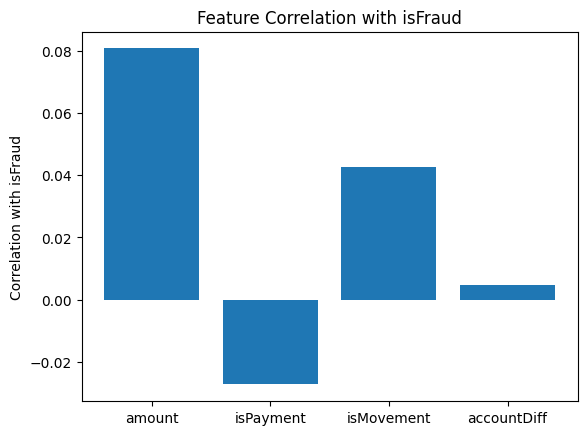

In [11]:
correlations = []
for col in features.columns:
    corr = np.corrcoef(transactions[col], transactions['isFraud'])[0, 1]
    correlations.append(corr)

plt.bar(features.columns, correlations)
plt.ylabel('Correlation with isFraud')
plt.title('Feature Correlation with isFraud')
plt.show()

## Distribution of Fraudulent Transactions

Text(0.5, 0, 'isFraud')

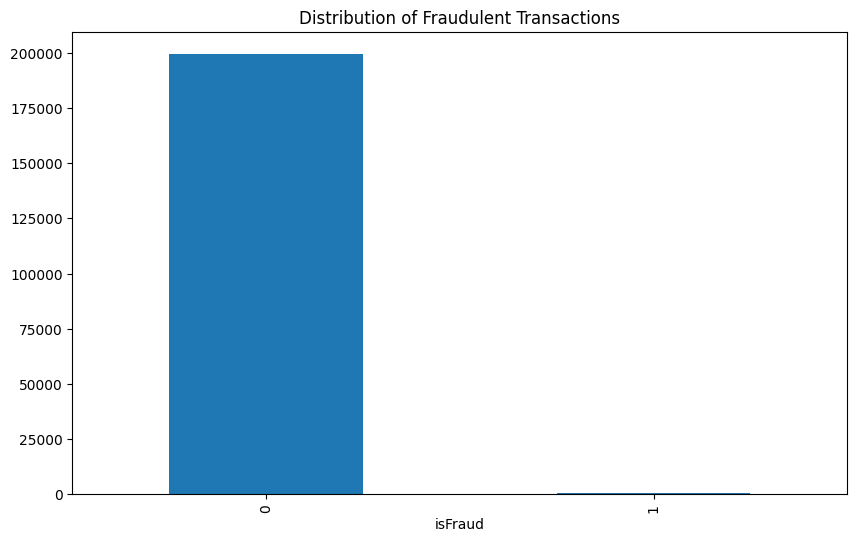

In [12]:
transactions['isFraud'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('isFraud')               

## SMOTE 

In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(features, label)


print(f"Original class distribution:\n{label.value_counts()}")
print(f"After SMOTE:\n{pd.Series(y_resampled).value_counts()}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, 
                                                    y_resampled, 
                                                    test_size=0.3,random_state=42)


Original class distribution:
isFraud
0    199717
1       282
Name: count, dtype: int64
After SMOTE:
isFraud
0    199717
1    199717
Name: count, dtype: int64


## Correlation Matrix

<Axes: >

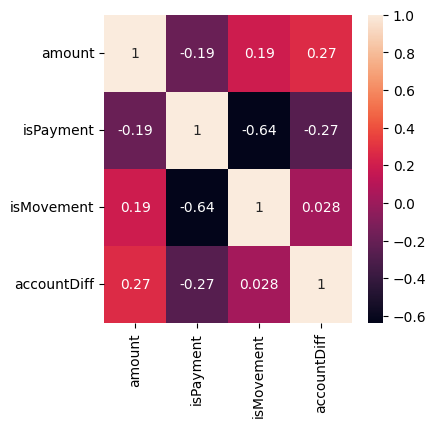

In [14]:
corr_matrix = features.select_dtypes('number').corr()
plt.figure(figsize=(corr_matrix.shape[0], corr_matrix.shape[1]))
sns.heatmap(corr_matrix, annot=True)


## Normalizing the features variables

In [15]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape,y_train.shape)

(279603, 4) (279603,)


# Evaluating models

In [16]:


## Logistic Regression Results
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

## KFold
kf=KFold(n_splits=5,shuffle=True ,random_state=42)

# Cross-validation
cv_results = cross_val_score(log_reg, X_resampled, y_resampled, cv=kf)

log_reg.fit(X_train_scaled, y_train)

print("\nModel Coefficients:")
print(log_reg.coef_)

print("\nCross Val Score:")
print(cv_results)
tests_score=log_reg.score(X_test_scaled, y_test)   

print("\nTest score:")
print(tests_score)

print("\nConfusion Matrix:")
y_pred = log_reg.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("\nClassification_score:")
cls_report = classification_report(y_test, y_pred)
print(cls_report)


Model Coefficients:
[[ 2.37237761 -0.87861392  4.47435994 -0.95807589]]

Cross Val Score:
[0.67154856 0.6726376  0.67133576 0.67333859 0.67173222]

Test score:
0.7997095910073353

Confusion Matrix:
[[38003 21991]
 [ 2010 57827]]

Classification_score:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     59994
           1       0.72      0.97      0.83     59837

    accuracy                           0.80    119831
   macro avg       0.84      0.80      0.79    119831
weighted avg       0.84      0.80      0.79    119831



# Testing and Predicting

In [17]:

# New transaction data
sample_transactions = np.array([
    [123456.78, 0.0, 1.0, 54670.1],
    [987644.43, 1.0, 0.0, 8524.75],
    [5436756.31, 1.0, 0.0, 510025.5],
    [646765.54, 1.0, 0.0, 55901.23]
])

# Normalize new data
sample_transactions_scaled = scaler.transform(sample_transactions)
# Predict fraud
predictions = log_reg.predict(sample_transactions_scaled)
#probabilities 
probabilities = log_reg.predict_proba(sample_transactions_scaled)
print("Fraud Predictions:", predictions)
print('-----------------------------------------')
print("Fraud Probabilities:", probabilities)

Fraud Predictions: [1 0 0 0]
-----------------------------------------
Fraud Probabilities: [[3.70618282e-01 6.29381718e-01]
 [9.99975545e-01 2.44553129e-05]
 [9.93489917e-01 6.51008308e-03]
 [9.99984400e-01 1.56001774e-05]]


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


---

## 📌 To-Do

* Add confusion matrix and classification report
* Try other models: Random Forest, XGBoost
* Handle class imbalance with oversampling / weighting

---